In [553]:
import import_ipynb
from Functions import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time
from torch import nn
from torchvision import transforms

# Add Inconsistency

In [554]:
def AddOneInc1(F):
    # Convert to NumPy Array
    F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255.0
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    x, y = random.randint(0, 2 * I.shape[0] // 3), random.randint(0, 2 * I.shape[1] // 3)
    # Random size
    l = random.randint(5, I.shape[1] // 20)
    # Random option
    Op = random.randint(0, 5)
    if Op == 0:
        I[x:x + l, y:y + l] = change_range_colors(
            I[x:x + l, y:y + l],
            (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)),
            (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))
        )
    elif Op == 1:
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (R, G, B), (R, G, B))
    elif Op == 2:
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1] // 15)
        I = cv2.line(I, (x, y), (x + l, y + l2), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3:
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1] // 20)
        I = cv2.line(I, (x, y), (x + l, y + l2), (0, 0, 0), Thick)
    elif Op == 4:
        I[x:x + l, y:y + l] = I[x:x + l, y:y + l] + np.random.randint(-10, 10, I[x:x + l, y:y + l].shape)
    else:
        kernel = np.random.rand(3, 3)
        I[x:x + l, y:y + l] = cv2.filter2D(I[x:x + l, y:y + l], -1, kernel)
    
    # Convert back to tensor
    I_tensor = torch.tensor(I, dtype=torch.float32).permute(2, 0, 1) / 255.0
    return I_tensor

# Calculate OF

In [555]:
def OF(img1: torch.Tensor, img2: torch.Tensor, alpha: float = 1.0, iterations: int = 100):
    assert img1.shape == img2.shape, "Images must have the same shape"

    def rgb_to_grayscale(img):
        return 0.2989 * img[0, :, :] + 0.5870 * img[1, :, :] + 0.1140 * img[2, :, :]

    I1 = rgb_to_grayscale(img1)
    I2 = rgb_to_grayscale(img2)

    # Initialize optical flow vectors (u for x direction, v for y direction)
    u = torch.zeros_like(I1, requires_grad=True)
    v = torch.zeros_like(I1, requires_grad=True)
    
    # Define convolution kernels for gradients
    kernel_x = torch.tensor([[[[-1, 1], [-1, 1]]]], dtype=torch.float32)
    kernel_y = torch.tensor([[[[-1, -1], [1, 1]]]], dtype=torch.float32)

    # Compute gradients with padding that maintains the original image size
    Ix = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_x, padding=(0, 1)).squeeze(0).squeeze(0)
    Iy = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_y, padding=(1, 0)).squeeze(0).squeeze(0)
    It = I2 - I1  # Temporal gradient

    # Ensure all tensors have matching dimensions
    min_h = min(Ix.shape[-2], Iy.shape[-2], It.shape[-2], I1.shape[-2])
    min_w = min(Ix.shape[-1], Iy.shape[-1], It.shape[-1], I1.shape[-1])

    Ix = Ix[:min_h, :min_w]
    Iy = Iy[:min_h, :min_w]
    It = It[:min_h, :min_w]
    u = u[:min_h, :min_w]
    v = v[:min_h, :min_w]

    # Iteratively update the optical flow
    for _ in range(iterations):
        u_avg = Fun.avg_pool2d(u.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        v_avg = Fun.avg_pool2d(v.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        
        P = Ix * u_avg + Iy * v_avg + It
        D = alpha ** 2 + Ix ** 2 + Iy ** 2
        
        u = u_avg - (Ix * P) / D
        v = v_avg - (Iy * P) / D

    flow = torch.stack((u, v), dim=0)
    return flow

# Calculate Difference in Frequency

In [556]:
def frequency_loss(image1, image2):
    freq_image1 = torch.fft.fft2(image1 * 255, dim=(-2, -1))
    freq_image2 = torch.fft.fft2(image2 * 255, dim=(-2, -1))
    mag_image1 = torch.abs(freq_image1)
    mag_image2 = torch.abs(freq_image2)
    loss = mag_image1 - mag_image2
    return loss

# Generate Parameters

In [557]:
def generate_params(N):
    k_pix = [torch.rand(3,3,3,3,requires_grad=True) for i in range(N)]
    k_dif = [torch.rand(3,3,3,3,requires_grad=True) for i in range(N)]
    k_freq = [torch.rand(3,3,3,3,requires_grad=True) for i in range(N)]
    k_of = [torch.rand(3,3,3,3,requires_grad=True) for i in range(N)]
    return k_pix,k_dif,k_freq,k_of,nn.Linear(3,1)

# Main Model

In [558]:
def Reduce(frame,k):
    if frame.shape != (1,3,256,256):
        print("Tensor not the right size.")
        return
    if k.shape != (3,3,3,3):
        print("Kernel not the right size.")
        return
    R = frame.clone()
    while R.shape[2]>1 and R.shape[3]>1:
        R = torch.relu(Fun.conv2d(R,k,stride=2,padding=1))
    return torch.relu(torch.mean(R))

In [585]:
def OFreduce(input_tensor, kernels):

    if input_tensor.ndim != 4 or input_tensor.size(1) != 2:
        raise ValueError("Input tensor must have shape (N, 2, 255, 255).")
    
    N, C, H, W = input_tensor.shape

    # Initialize a list to hold the results
    results = []

    for kernel in kernels:
        if kernel.ndim != 2:
            raise ValueError("Each kernel must be a 2D tensor.")
        kernel_expanded = kernel.unsqueeze(0).expand(C, -1, -1)  # Match input channels
        kernel_expanded = kernel_expanded.unsqueeze(0)  # Add batch dimension for conv2d
        
        # Perform convolution
        output = Fun.conv2d(input_tensor, kernel_expanded, groups=C)  # (N, 1, H', W')
        results.append(output.mean(dim=(1, 2, 3)))  # Aggregate result (N,)
    
    # Combine results (e.g., sum or average)
    final_result = torch.stack(results, dim=1).mean(dim=1)  # Shape: (N,)
    return final_result

In [559]:
def GenFun(frames,dframes,fframes,k_pix,k_dif,k_freq,Lineal):#,k_freq,k_of,fframes,offrames):
    N = frames.shape[0]
    framesR = torch.stack([Reduce(f.unsqueeze(0),k) for f,k in zip(frames,k_pix)])
    dframesR = torch.stack([Reduce(f.unsqueeze(0),k) for f,k in zip(dframes,k_dif)])
    fframesR = torch.stack([Reduce(f.unsqueeze(0),k) for f,k in zip(fframes,k_freq)])
    framesR = torch.mean(framesR/(torch.max(framesR)+0.001))
    dframesR = torch.mean(dframesR/(torch.max(dframesR)+0.001))
    fframesR = torch.mean(fframesR/(torch.max(fframesR)+0.001))
    stack = torch.stack([framesR,dframesR,fframesR])
    return torch.sigmoid(Lineal(stack))

# Get Training Data

In [560]:
def get_video_frames(path, N, size):
    # Find all video files in the specified path
    video_files = [f for f in os.listdir(path) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if not video_files:
        raise ValueError("No video files found in the specified path.")
    
    # Choose a random video file
    video_file = random.choice(video_files)
    video_path = os.path.join(path, video_file)
    
    # Initialize the video capture
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If N is larger than the number of frames in the video, adjust it
    if N > total_frames:
        raise ValueError(f"The video has only {total_frames} frames, but {N} frames were requested.")
    
    # Select a random starting frame index such that we can capture N consecutive frames
    start_frame = random.randint(0, total_frames - N)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Resize transformation
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    
    frames = []
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame (BGR to RGB) and apply the resize transform
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = transform(frame_rgb)
        frames.append(frame_tensor)
    
    cap.release()
    
    # Stack frames and reshape to the desired output shape
    frames_tensor = torch.stack(frames).unsqueeze(0)  # Shape (1, N, 3, H, W)
    
    return frames#_tensor

# Convert Tensor to Numpy List

In [561]:
def t2nl(frames_tensor):
    # Remove the batch dimension (1, N, 3, H, W) -> (N, 3, H, W)
    frames_tensor = frames_tensor.squeeze(0)
    
    # Convert each frame tensor to a NumPy array
    frame_list = [cv2.cvtColor(frame.permute(1, 2, 0).numpy(),cv2.COLOR_BGR2RGB) for frame in frames_tensor]
    
    return frame_list

# Training Function

In [562]:
def train(Path, State=None, N=3, Batch=10, Epochs=10, Steps=5, LR=1e-3):
    k_pix, k_dif, k_freq, k_of, Lineal = generate_params(N)
    Size = (256, 256)
    
    if State is not None:
        model.load_state_dict(State)

    Loss = []
    LMin = 1e20

    start_time = time.time()  # Start timer

    for epoch in range(Epochs):
        epoch_start_time = time.time()  # Timer for each epoch
        
        optimizer = optim.Adam(k_pix + k_dif + k_freq + list(Lineal.parameters()), lr=LR)
        total_loss = 0.0

        for batch in range(Batch):
            optimizer.zero_grad()
            
            Frames = get_video_frames(Path, N, Size)
            Frames = torch.stack(Frames)
    
            Target = torch.tensor([0.0]) if random.random() >= 0.5 else torch.tensor([1.0])

            if Target.item() == 1.0:
                steps = random.randint(1, Steps)
                for s in range(steps):
                    Frames[N // 2] = AddOneInc1(Frames[N // 2])

            # Difference Frames
            diff_frames = [Frames[i + 1] - Frames[i] for i in range(len(Frames) - 1)]
            diff_frames = torch.stack(diff_frames)
            
            # Frequency Frames
            freq_frames = [frequency_loss(Frames[i + 1], Frames[i]) for i in range(len(Frames) - 1)]
            freq_frames = torch.stack(freq_frames)
            
            # OF Frames
            of_frames = [OF(Frames[i + 1], Frames[i]) for i in range(len(Frames) - 1)]
            of_frames = torch.stack(of_frames)
            print(of_frames.shape)
            
            # Forward pass
            Pred = GenFun(Frames, diff_frames, freq_frames, k_pix, k_dif, k_freq, Lineal)
            
            # Calculate loss
            criterion = nn.BCELoss()
            loss = criterion(Pred, Target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            elapsed_time = time.time() - start_time
            avg_time_per_iter = elapsed_time / ((epoch * Batch) + batch + 1)
            remaining_iters = (Epochs * Batch) - ((epoch * Batch) + batch + 1)
            remaining_time = avg_time_per_iter * remaining_iters

            print(f'LR: {LR:0.4} Batch [{batch+1}/{Batch}], Loss: {loss.item():.4f} Time:{remaining_time / 60:.2f} minutes', end='\r')

            # Display predictions on the frame
            Frame = cv2.cvtColor(Frames[N // 2].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)
            Frame = cv2.putText(Frame, f'P: {round(Pred.item())}', (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
            Frame = cv2.putText(Frame, f'T: {int(Target.item())}', (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
            cv2.imshow("Frame", Frame)
            cv2.waitKey(1)

        Loss.append(total_loss)
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / Batch:.6f}')
        
        LR *= 0.9
    
    cv2.destroyAllWindows()
    return Loss

# Training

In [563]:
cv2.destroyAllWindows()

In [564]:
State = None

In [576]:
L,Parameters = train('VDB',Batch=1,State=State,N=5,Epochs=2,Steps=10,LR=1e-1)

torch.Size([4, 2, 255, 255])
LR: 0.1 Batch [1/1], Loss: 0.8160 Time:0.02 minutes
Epoch [1/2], Loss: 0.816040
Time taken for epoch: 1.13 seconds

torch.Size([4, 2, 255, 255])
LR: 0.09 Batch [1/1], Loss: 0.6902 Time:0.00 minutes
Epoch [2/2], Loss: 0.690234
Time taken for epoch: 1.28 seconds



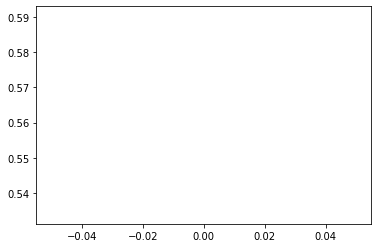

In [566]:
plt.plot(L)

In [567]:
def Prediction(video, model, model_state, N, H, W):
    # Load the model state
    model.load_state_dict(model_state)
    model.eval()  # Set model to evaluation mode
    outputs = []
    # Iterate over the video in steps of N frames
    num_frames = len(video)
    for i in range(0, num_frames - N + 1):
        # Extract the stack of frames
        frame_stack = video[i:i + N]  # Shape: (N, H, W, C)
        # Convert to numpy array and add batch dimension
        frame_stack = np.array(frame_stack)  # Shape: (N, H, W, C)
        # Rearrange to match the model's expected input shape: (batch, N, C, H, W)
        # In our case, the frame_stack shape should be (1, N, 3, H, W) where 3 is the number of channels (RGB)
        frame_stack = np.transpose(frame_stack, (0, 3, 1, 2))  # Shape: (N, C, H, W)
        frame_stack = np.expand_dims(frame_stack, axis=0)  # Shape: (1, N, C, H, W)
        # Convert to a PyTorch tensor
        frame_stack = torch.tensor(frame_stack, dtype=torch.float32)
        # Forward pass through the model
        with torch.no_grad():
            output = model(frame_stack)
        # Append the output to the list
        outputs.append(int(round(output.item())))
    return outputs

In [568]:
#cap = open_vid("AI Gen/movie.mp4")
#Video = get_frames(cap)
#VI = torch.from_numpy(Video[5]).permute(2,0,1).unsqueeze(0)
#VI = AddOneInc1(VI)
#Video[5] = cv2.cvtColor(VI.permute(1, 2, 0).numpy(),cv2.COLOR_BGR2RGB)
#display_frame(Video[5])

In [569]:
#Video = [cv2.resize(i,(100,100)) for i in Video[:15]]
#Preds = process_video(Video,Model,State,3,100,100)
#Preds

In [570]:
def Prediction(Vid,Model,State,N,Size):
    model = BinIncModel(N,Size(0),Size(1))
    P = []
    V = [torch.tensor(cv2.resize(i,(320,320),interpolation=cv2.INTER_AREA),
                              dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0 for i in Vid]
    
    N = len(kt)//2
    for f in range(len(V) - 2 * N):
        first, current, last = f, f + N // 2, f + N
        Pred = ObjFun(V[first:last], V[current], k, kt, kb)
        P.append(cv2.resize((Pred[0] * 255).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8),
                                           (Vid[f].shape[1], Vid[f].shape[0]), interpolation=cv2.INTER_AREA))
    return P

In [571]:
#PVid = Prediction(Video,Parameters)

In [572]:
#ThroughFrames(Video)

In [573]:
#ThroughFrames(PVid)

In [574]:
##Add detail error, MSE of full image only minimizes general pixel distribution
##Add more training examples
##Add N previous and N post current inconsistence image
##Add optical flow, frequencies or other features for temporal consistency
##Different kernel sizes
##Add Gaisian Noise
##Reconstruct image with kernel middle between encoder and decofer
##Use data with less loss value, selection
##How to combine data with less error and with more error?
##Localize area and correct error

In [575]:
#deformaciones
#parches de colores, OF ventana
#self attention mechanism
#image processing transformer